<a href="https://colab.research.google.com/github/sayantika21175/AI_AGENT/blob/main/ReActAGENT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [279]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated , List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline


memory=SqliteSaver.from_conn_string(":memory:")



In [280]:
import torch

In [4]:
# %pip install -U langgraph langsmith langchain_anthropic
# !pip install langgraph-checkpoint-sqlite
# !pip install tavily-python

In [281]:
class Agentstate(TypedDict):
  task:str
  plan:str
  draft:str
  critique:str
  content:List[str]
  revision_no: int
  max_iter: int

In [282]:
# import transformers

# pipeline= transformers.pipeline("text-generation", model="microsoft/phi-4",model_kwargs={"torch_dtype": "auto"},device_map="auto")

In [283]:
# torch.random.manual_seed(0)
# model = AutoModelForCausalLM.from_pretrained(
#     "microsoft/Phi-3-mini-4k-instruct",
#     device_map="auto",
#     torch_dtype="auto",
#     trust_remote_code=True,
# )
# tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

In [284]:
#pipe=pipeline("text-generation",model=model,tokenizer=tokenizer)

In [285]:
# generation_args = {
#     "max_new_tokens": 500,
#     "return_full_text": False,
#     "temperature": 0.0,
#     "do_sample": False,
# }

In [286]:
Plan_prompt="""you are an expert writer tasked with writting a high level outline of an essay.\
Write such an outline for the user provided topic. give an outline of the essay along with any relevant notes\
or instructions for the sections."""


In [287]:
Writer_prompt="""you are as essay assistant tasked with writing excellent 5 paragraph essays.\
generate the best essay possible for the user's request and the initial outline.\
if the user provides critique, respond with a revised version of your previous attempts .\
utilise all the information below as needed:
--------

{content}"""

In [288]:
Refelection_prompt="""you are a teacher grading an essay submission.\
Generate critique and recommendations for the user's submission.\
Provide detailed recommendations, including requests for length, depth, style, etc"""

In [289]:
Research_plan_prompt="""you are a researcher chargded with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather\
any relevant information. only generate 3 queries max"""

In [290]:
research_critique_prompt="""you are a researcher charged with providing information that can\
be used when making any requested revisions (as outlined below).\
Generate a list of search quaries that will gather any relevant information. only generate 3 queries max"""

In [291]:
from langchain_core.pydantic_v1 import BaseModel,Field

class Queries(BaseModel):
  queries:List[str]
# class Queries(BaseModel):
#     setup: str = Field(description="The list of the strings")

In [240]:
# class Joke(BaseModel):
#     setup: str = Field(description="The setup of the joke")

In [239]:
# from pydantic import BaseModel
# class Queries(BaseModel):
#     '''An answer to the user question along with justification for the answer.'''
#     answer: list[str]

In [241]:
# from google.colab import userdata
# app_key=userdata.get('hugging_face')
# #app_key

In [242]:
# from google.colab import userdata
# google_key=userdata.get('googl_api')
# #app_key

In [243]:
#!pip install -qU langchain-google-vertexai

In [235]:
import getpass
import os

os.environ["MISTRAL_API_KEY"] = getpass.getpass()

··········


In [236]:
%pip install -qU langchain_mistralai

In [248]:
from langchain_mistralai import ChatMistralAI

model_mistral = ChatMistralAI(model="mistral-large-latest")

In [226]:
# from langchain_google_vertexai import ChatVertexAI

# chat = ChatVertexAI(model="gemini-pro")

In [244]:
# from huggingface_hub import login
# login(app_key)

In [245]:
# from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

# llm = HuggingFaceEndpoint(
#     repo_id="microsoft/Phi-3-mini-4k-instruct",
#     task="text-generation",
#     max_new_tokens=512,
#     do_sample=False,
#     repetition_penalty=1.03,
# )

# chat = ChatHuggingFace(llm=llm, verbose=True)

In [155]:
# from langchain.output_parsers import PydanticOutputParser
# parser=PydanticOutputParser(pydantic_object=Queries)

In [246]:
from tavily import TavilyClient
tavily=TavilyClient(api_key="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")

In [184]:
tavily.search("what is langchain",max_results=2)

{'query': 'what is langchain',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Introduction | ️ LangChain',
   'url': 'https://python.langchain.com/docs/introduction/',
   'content': "How to use tools in a chain How to migrate from legacy LangChain agents to LangGraph How to use chat models to call tools LangChain is a framework for developing applications powered by large language models (LLMs). Development: Build your applications using LangChain's open-source building blocks, components, and third-party integrations. langchain: Chains, agents, and retrieval strategies that make up an application's cognitive architecture. LangServe: Deploy LangChain chains as REST APIs. LangSmith: A developer platform that lets you debug, test, evaluate, and monitor LLM applications. Build stateful, multi-actor applications with LLMs. Integrates smoothly with LangChain, but can be used without it. LangChain is part of a rich ecosystem of tools that integrate with

In [292]:
def plan_node(state:Agentstate):
  messages=[
      ("system",Plan_prompt),
      ("human",state["task"])
  ]
  response=model_mistral.invoke(messages)
  return {"plan":response.content}

In [306]:
def get_research_plan(state:Agentstate):
  messages=model_mistral.with_structured_output(Queries).invoke([
      ("system",Research_plan_prompt),
      ("human",state["task"])]
  )
  #structured_output=parser.parse(messages.content)
  content=state.get("content", [])
  for q in messages.queries:
    result=tavily.search(q,max_results=2)
    for i in result['results']:
      content.append(i['content'])
  return {"content":content}

In [250]:
messages=model_mistral.with_structured_output(Queries).invoke([
      ("system","you are an assistant. give proper answer in three lines"),
      ("human","what is llm?")
  ])
# structured_output=parser.parse(str(messages.content))
# structured_output
messages
#print(parser.parse("what is your name?"))

Queries(queries=['what is llm'])

In [342]:
def generation_node(state: Agentstate):
  content="\n\n".join(state["content"] or [])
  user_message=("human",f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
  messages=[
      ("system",Writer_prompt.format(content=content)),
      user_message
  ]
  response=model_mistral.invoke(messages)
  print(f"current revision number: {state.get('revision_no')}")
  return {"draft":response.content,
          "revision_no": state.get("revision_no",1)+1}


In [253]:
def reflection_node(state:Agentstate):
  messages=[
      ("system",Refelection_prompt),
      ("human",state["draft"])
  ]
  response=model_mistral.invoke(messages)
  return {"critique":response.content}

In [319]:
def get_critique_node(state:Agentstate):
  messages=model_mistral.with_structured_output(Queries).invoke([
      ("system",research_critique_prompt),
      ("human",state["critique"])
  ])
  content=state.get("content", [])
  for q in messages.queries:
    result=tavily.search(q,max_results=2)
    for i in result['results']:
      content.append(i['content'])
  return {"content":content}


In [343]:
def should_continue(state:Agentstate):
  if state["revision_no"]>state["max_iter"]:
    return END
  else:
    return "reflect"

In [344]:
builder=StateGraph(Agentstate)

In [345]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [346]:
builder.add_node("planner",plan_node)
builder.add_node("research_plan",get_research_plan)
builder.add_node("generate",generation_node)
builder.add_node("reflection",reflection_node)
builder.add_node("research_critique",get_critique_node)

In [347]:
builder.set_entry_point("planner")

In [348]:
builder.add_conditional_edges(
    "generate",
    should_continue,
    {END:END,"reflect":"reflection"}

)

In [349]:
builder.add_edge("planner","research_plan")
builder.add_edge("research_plan","generate")

builder.add_edge("reflection","research_critique")
builder.add_edge("research_critique","generate")

In [350]:
#with SqliteSaver.from_conn_string(":memory:") as memory:
graph=builder.compile(checkpointer=memory)

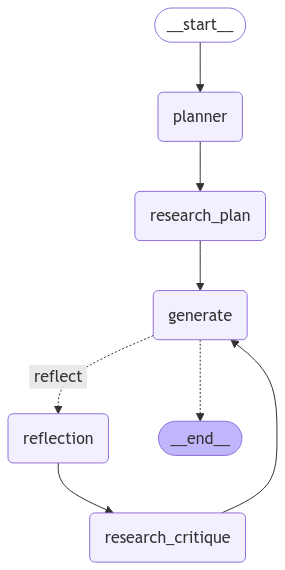

In [351]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)




In [352]:
import warnings
warnings.filterwarnings("ignore")

In [90]:
# messages = [
#     {"role": "system", "content": "You are a helpful AI assistant."},
#     {"role": "user", "content": "Can you provide ways to eat combinations of bananas and dragonfruits?"},
#     {"role": "assistant", "content": "Sure! Here are some ways to eat bananas and dragonfruits together: 1. Banana and dragonfruit smoothie: Blend bananas and dragonfruits together with some milk and honey. 2. Banana and dragonfruit salad: Mix sliced bananas and dragonfruits together with some lemon juice and honey."},
#     {"role": "user", "content": "What about solving an 2x + 3 = 7 equation?"},
# ]


In [353]:
thread={"configurable":{"thread_id":"1"}}
response=""

for s in graph.stream(
    {
        'task':"What is the difference between Langchain and Langsmith?",
        "max_iter":2,
        "revision_no":1
    },thread):
  print(s)

  # if isinstance(s,SystemMessage):
  #   response+=s.content
  # elif isinstance(s,str):
  #   response+=s
  # else:
  #   response+=str(s)
  # print(response)

{'planner': {'plan': '**Essay Outline: The Difference between LangChain and LangSmith**\n\n**I. Introduction**\n  - A. Briefly introduce the concept of large language models (LLMs) and their increasing importance in AI.\n  - B. Introduce LangChain and LangSmith as two prominent tools in the LLM ecosystem.\n  - C. Thesis Statement: While LangChain and LangSmith both serve to enhance the capabilities of LLMs, they differ in their core functionalities, use cases, and approaches to approach LLM implementation.\n\n**II. Understanding LangChain**\n  - A. **Definition and Purpose**\n     - 1. Define LangChain and its primary goals.\n     - 2. Explain its role in facilitating the interaction between LLMs and other tools or data sources.\n  - B. **Key Features**\n     - 1. Modularity: Discuss how LangChain allows users to combine different components to create custom LLM applications.\n     - 2. Chains: Explain the concept of "chains" in LangChain, which allow for sequential processing of langu

In [173]:
messages = [
    ("system", "You are a helpful assistant. provide the answer precisely.If you do not know say you do not know."),
    ("human", "What is the difference between Langchain and Langsmith?."),
]

res=chat.invoke(messages)
#structured_op=parser.parse(res.content)
#structured_op

In [105]:
res['AIMessage']

TypeError: 'AIMessage' object is not subscriptable

In [174]:
res.content

'Langchain and Langsmith are not widely recognizable entities as of my knowledge cutoff in 2023, which might be due to them being relatively new concepts, private projects, or specific tools within certain communities, or even having similar names that cause some confusion.\n\nIf you are referring to software frameworks or development tools in AI and programming fields, some of the likely options you might be considering could be "Langchain" and "Lambda School".\n\nLangchain might be a term you would come across in discussions about AI and data processing, referring to a chain of language processing functions. However, without specific information, there\'s no standard definition or application. You might be talking about a particular proprietary technology at a company, such as Google\'s Langchain, which is a new tech product that has been rumored to be focused on high-performance AI applications using Google\'s technologies.\n\nLambda School, on the other hand, is a very well-known o

In [94]:
#!pip install langchain-huggingface

In [95]:
from huggingface_hub import login
login() # You will be prompted for your HF key, which will then be saved locally

In [45]:
thread={"configurable":{"thread_id":"1"}}

In [46]:
response = ""

for s in graph.stream(
    {
        'task': "What is the difference between Langchain and Langsmith?",
        "max_iter": 3,
        "revision_number": 1
    },
    thread
):
    try:
        # Attempt to extract content if it has a content attribute
        response += getattr(s, "content", str(s))
    except Exception as e:
        print(f"Error processing: {s}, Exception: {e}")

    print(response)


TypeError: can only concatenate str (not "SystemMessage") to str